In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-hindi/classification-movie-review


In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-hindi/classification-movie-review')

In [6]:
df_train = pd.read_csv(path/'train.csv')
df_train.head()

,text,experience
0,चंद्रमोहन शर्मा को-प्रड्यूसर और लीड ऐक्टर अक्ष...,2
1,अगर आप इस फिल्म को देखने जा रहे हैं तो सबसे पह...,0
2,बॉलीवुड वाले चोरी-छिपे हॉलीवुड फिल्मों से कहान...,2
3,"बैनर :\nसंजय दत्त प्रोडक्शन्स प्रा.लि., रुपाली...",0
4,1959 में घटित चर्चित नानावटी कांड में एक क्राइ...,1


In [7]:
df_valid = pd.read_csv(path/'valid.csv')
df_valid.head()

,text,experience
0,"\n\nबैनर :\nनेक्स्ट जेन फिल्म्स प्रोडक्शन्स, इ...",2
1,इस शुक्रवार रिलीज हुई इकलौती इस हॉलिवुड मूवी क...,2
2,"\n\nबैनर :\nयूटीवी मोशन पिक्चर्स, टिप्स म्युजि...",1
3,"चंद्रमोहन शर्मा, नवभारत टाइम्स पिछले कुछ अर्से...",0
4,\n\nशनाया ग्रोवर (मंजरी फडणीस) पर हत्या का आरो...,0


In [8]:
df_train.shape, df_valid.shape

((718, 2), (180, 2))

In [10]:
for df in [df_train, df_valid]:
    if len(df) == 718:
        print('In Training Set:')
    else:
        print('In Valid Set:')
    print('Positive Examples', (df['experience'] == 2).sum())
    print('Neutral Examples', (df['experience'] == 1).sum())
    print('Negative Examples', (df['experience'] == 0).sum())
    print('\n\n\n')

In Training Set:
Positive Examples 273
Neutral Examples 205
Negative Examples 240




In Valid Set:
Positive Examples 62
Neutral Examples 65
Negative Examples 53






In [11]:
df_train['text'][0]

'चंद्रमोहन शर्मा को-प्रड्यूसर और लीड ऐक्टर अक्षय कुमार की मानें तो उनकी नई फिल्म एयरलिफ्ट की कहानी और किरदार बिल्कुल सच्चे हैं। पहले खाड़ी युद्ध को कवर करने वाले एक सीनियर रिपोर्टर और उस वक्त एयर इंडिया में उच्च पद पर रहे एक अफसर इस कहानी को सच से परे मानते हैं। हालांकि, स्क्रीन पर आप जो कुछ भी देखेंगे वह सब सच के बेहद करीब है। बॉलिवुड की खबरें अपने फेसबुक पर पाना हो तो लाइक करें Nbt Movies फिल्म की कहानी चार अहम किरदारों के इर्द-गिर्द घूमती है। इन चारों को मिलाकर एक लीड किरदार स्क्रीन पर उतारा गया है, जिसे अक्षय कुमार ने निभाया है। यह फिल्म पहले खाड़ी युद्ध पर आधारित है। इस जंग के दौरान कुवैत में फंसे करीब एक लाख सत्तर हजार भारतीय नागरिकों को देश वापस लाए जाने की घटना को डायरेक्टर ने अपने अंदाज से पेश किया है। किरदारों को पर्दे पर उतारने में कुछ फिल्मी आजादी की जरूरत होती है, यही आजादी फिल्म के डायरेक्टर राजा मेनन ने भी ली है। देखिए, फिल्म का ट्रेलर  इस घटना को और ज्यादा असरदार ढंग से पेश करने के मकसद से राजा ने फिल्म के कुछ सीन्स को दुबई से करीब चार घंटे की दूरी पर स्थित रसेल खेमा मे

In [12]:
df_train[df_train['text'].isnull()].shape

(0, 2)

In [13]:
df_valid[df_valid['text'].isnull()].shape

(0, 2)

In [14]:
label_cols = list(range(1,df_train.shape[1]))

In [15]:
print(label_cols)

[1]


In [16]:
id_to_col = list(df.columns)

In [17]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [18]:
class HindiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/'../tokenizer/hindi_lm.model'))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [19]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/'../tokenizer/hindi_lm.model'))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [20]:
itos[:10]

['<unk>', '<s>', '</s>', '▁के', '।', '▁में', '▁है', ',', '▁', '▁की']

In [21]:
# 30,000 is the vocab size that we chose in sentencepiece
hindi_vocab = Vocab(itos)

In [22]:
tokenizer = Tokenizer(tok_func=HindiTokenizer, lang='hi')

In [23]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [33]:
data_lm = TextLMDataBunch.from_df(path=path, train_df=df_train, valid_df=df_valid, text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=hindi_vocab, bs=16)

In [34]:
data_lm.save()

In [36]:
data_lm.show_batch()

idx,text
0,"▁अक्षय ▁कुमार ▁ने ▁निभाया ▁है । ▁यह ▁फिल्म ▁पहले ▁खाड़ी ▁युद्ध ▁पर ▁आधारित ▁है । ▁इस ▁जंग ▁के ▁दौरान ▁कुवैत ▁में ▁फंसे ▁करीब ▁एक ▁लाख ▁सत्तर ▁हजार ▁भारतीय ▁नागरिकों ▁को ▁देश ▁वापस ▁लाए ▁जाने ▁की ▁घटना ▁को ▁डायरेक्टर ▁ने ▁अपने ▁अंदाज ▁से ▁पेश ▁किया ▁है । ▁किरदार ों ▁को ▁पर्दे ▁पर ▁उतारने ▁में ▁कुछ ▁फिल्म ी ▁आजादी ▁की ▁जरूरत ▁होती ▁है , ▁यही ▁आजादी ▁फिल्म ▁के ▁डायरेक्टर ▁राजा ▁मेनन ▁ने"
1,▁समझता । ▁उसका ▁मानना ▁है ▁कि ▁आदमी ▁जिंदगी ▁भर ▁दाल - चा ं वल ▁खाकर ▁कैसे ▁गुजारा ▁कर ▁सकता ▁है ? ▁वैसे ▁भी ▁आजकल ▁फिल्मों ▁में ▁दिखाए ▁जाने ▁वाले ▁ज्यादातर ▁हीरो ▁/ ▁हीरो इन ों ▁को ▁शादी ▁पर ▁विश्वास ▁नहीं ▁है । ▁पिछले ▁सप्ताह ▁रिलीज ▁हुई ▁‘ इश ्क ▁इन ▁पेरिस ’ ▁के ▁हीरो ▁का ▁भी ▁यही ▁सोचना ▁था । ▁बनी ▁की ▁सोच ▁आज ▁के ▁युवाओं ▁की ▁शादी ▁के ▁प्रति
2,मल ▁ <unk> कुल भूषण ▁खरब ंदा ) ▁अपने ▁राज्य ▁की ▁प्रजा ▁के ▁हितों ▁को ▁ध्यान ▁में ▁रखकर ▁मुगलों ▁से ▁दोस्ती ▁करने ▁का ▁फैसला ▁करता ▁है । ▁भार मल ▁चाहता ▁है ▁कि ▁उसकी ▁बेटी ▁जो धा ▁ <unk> ऐ श्वर ्या ) ▁से ▁अकबर ▁शादी ▁करें । ▁बिना ▁जो धा ▁को ▁देखे ▁अकबर ▁निक ाह ▁के ▁लिए ▁राजी ▁हो ▁जाता ▁है । ▁जो धा ▁निक ाह ▁करने ▁के ▁पहले ▁अकबर
3,"▁का ▁है । ▁राज ू ▁को ▁विश्वास ▁है ▁कि ▁यह ▁रेस ▁जीतकर ▁वह ▁अपने ▁और ▁परिवार ▁वालों ▁के ▁सपनों ▁को ▁पूरा ▁कर ▁पाएगा । ▁इस ▁रेस ▁का ▁आयोजन ▁वीर ू ▁ <unk> जॉन ी ▁लीवर ) ▁करता ▁है , ▁जो ▁मुंबई ▁ऑटो ▁रिक्शा ▁यूनियन ▁का ▁लीडर ▁है । ▁वह ▁' भाई ' ▁किस्म ▁का ▁आदमी ▁है ▁और ▁इस ▁रेस ▁को ▁जीतने ▁के ▁लिए ▁साजिश ▁रच ता ▁है । ▁कैसे ▁राज"
4,"▁ठग ा ▁पाए ंगे । ▁x x bo s ▁चं पक ▁ <unk> रित ेश ▁देशमुख ) , ▁गुलाब ▁ <unk> भुव न ▁अर ोरा ) ▁और ▁गेंद ा ▁ <unk> विक्रम ▁थापा ) ▁जेब कत रे ▁हैं । ▁एक ▁ही ▁दांव ▁में ▁ज्यादा ▁से ▁ज्यादा ▁पैसा ▁पाने ▁के ▁चक्कर ▁में ▁बैंक ▁में ▁डाक ा ▁डालने ▁पहुंच ▁जाते ▁हैं । ▁बैंक ▁डकैती ▁वाले ▁दिन ▁उनके ▁सारे ▁दांव ▁उल्ट े ▁पड़"


In [42]:
awd_lstm_config = awd_lstm_lm_config.copy()
awd_lstm_config['n_hid'] = 1150

In [44]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, config=awd_lstm_config, pretrained=False)

In [45]:
path

PosixPath('/home/gaurav/PycharmProjects/nlp-for-hindi/classification-movie-review')

In [46]:
# Loading the pretrained language model on hindi wikipedia
learn.load(path/'../language-model/HindiDataset/ulmfit/models_ulmfit/third_hi_lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (718 items)
x: LMTextList
▁x x bo s ▁चंद्र मोहन ▁शर्मा ▁को - प्र ड्यू सर ▁और ▁ली ड ▁ऐक्ट र ▁अक्षय ▁कुमार ▁की ▁माने ं ▁तो ▁उनकी ▁नई ▁फिल्म ▁एयर लि फ्ट ▁की ▁कहानी ▁और ▁किरदार ▁ बिल्कुल ▁ सच्चे ▁हैं । ▁पहले ▁खाड़ी ▁युद्ध ▁को ▁कवर ▁करने ▁वाले ▁एक ▁सीनियर ▁रिपोर्ट र ▁और ▁उस ▁वक्त ▁एयर ▁इंडिया ▁में ▁उच्च ▁पद ▁पर ▁रहे ▁एक ▁अफसर ▁इस ▁कहानी ▁को ▁सच ▁से ▁परे ▁मानते ▁हैं । ▁हालांकि , ▁स्क्रीन ▁पर ▁आप ▁जो ▁कुछ ▁भी ▁देखेंगे ▁वह ▁सब ▁सच ▁के ▁बेह द ▁करीब ▁है । ▁बॉल ि वुड ▁की ▁खबर ें ▁अपने ▁फेसबुक ▁पर ▁पाना ▁हो ▁तो ▁लाइक ▁करें <unk> ▁n b t <unk> ▁m ov ies ▁फिल्म ▁की ▁कहानी ▁चार ▁अहम ▁किरदार ों ▁के ▁इर्द - गिर्द ▁घूमती ▁है । ▁इन ▁चारों ▁को ▁मिलाकर ▁एक ▁ली ड ▁किरदार ▁स्क्रीन ▁पर ▁उतारा ▁गया ▁है , ▁जिसे ▁अक्षय ▁कुमार ▁ने ▁निभाया ▁है । ▁यह ▁फिल्म ▁पहले ▁खाड़ी ▁युद्ध ▁पर ▁आधारित ▁है । ▁इस ▁जंग ▁के ▁दौरान ▁कुवैत ▁में ▁फंसे ▁करीब ▁एक ▁लाख ▁सत्तर ▁हजार ▁भारतीय ▁नागरिकों ▁को ▁देश ▁वापस ▁लाए ▁जाने ▁की ▁घटना ▁को ▁डायरेक्टर ▁ने ▁अपने ▁अंदाज ▁से ▁पेश ▁किया ▁ह

In [47]:
# Fine tuning the prtrained LM on current dataset

In [48]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


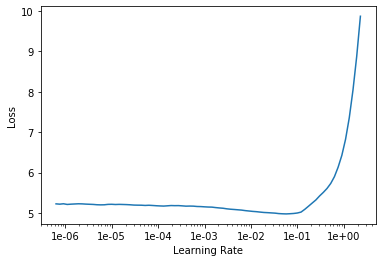

In [49]:
learn.recorder.plot()

In [50]:
learn.freeze()

In [51]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.225928,4.068161,0.326195,00:48


In [52]:
learn.save('fit_head', with_opt=True)

In [53]:
learn.load('fit_head', with_opt=True);

In [54]:
learn.unfreeze()

In [55]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.708985,3.926353,0.341945,00:54
1,3.561784,3.801083,0.358138,00:55
2,3.287397,3.750536,0.367112,00:55
3,3.016161,3.748087,0.369752,00:55
4,2.853555,3.762752,0.369309,00:55


In [56]:
learn.save('fine_tuned', with_opt=True)

In [57]:
learn.load('fine_tuned', with_opt=True);

In [58]:
learn.predict('जिसके लिये उन्हें',n_words=10)

"जिसके लिये उन्हें ▁' लै ला ▁खोया ▁है ' ▁और ▁अर्जुन ▁खरब ंदा"

In [59]:
learn.save_encoder('fine_tuned_enc')

In [60]:
data_clas = TextClasDataBunch.from_df(path=path, train_df=df_train, valid_df=df_valid, tokenizer=tokenizer, vocab=hindi_vocab, text_cols=[0], label_cols=label_cols, bs=16)

In [61]:
data_clas.show_batch()

text,target
"▁x x bo s ▁राजकुमार ▁ही रानी ▁जैसे ▁ऊंचे ▁कद ▁के ▁निर्देशक ▁के ▁लिए ▁संजय ▁दत्त ▁जैसा ▁विषय ▁स्तर ▁से ▁नीचे ▁है । ▁आखिर ▁संजय ▁दत्त ▁के ▁जीवन ▁में ▁ऐसा ▁क्या ▁है ▁कि ▁ही रानी ▁को ▁उस ▁पर ▁फिल्म ▁बनाने ▁की ▁जरूरत ▁महसूस ▁हो । ▁नि : संदेह ▁संजय ▁के ▁जीवन ▁में ▁कई ▁ऐसे ▁उतार - चढ़ाव ▁हैं ▁जिस ▁पर ▁कम र् शियल ▁फिल्म ▁बनाई ▁जा ▁सकती ▁है , ▁लेकिन",2
▁x x bo s ▁भारत - पाकिस्तान ▁के ▁खट्टे - मी ठे ▁रिश्तों ▁ने ▁हमेशा ▁ही ▁फिल्म कारों ▁को ▁आकर्षित ▁किया ▁है । ▁गदर ▁जैसी ▁फिल्मों ▁में ▁खट्टा ▁ज्यादा ▁था ▁तो ▁' ब ज रंगी ▁भाई जान ' ▁में ▁इन ▁पड़ोसी ▁देशों ▁के ▁बारे ▁में ▁मिठास ▁ज्यादा ▁मिलती ▁है । ▁गदर ▁में ▁अपनी ▁पत्नी ▁को ▁लेने ▁के ▁लिए ▁सन ी ▁देओल ▁पाकिस्तान ▁में ▁जा ▁खड़े ▁हुए ▁और ▁पूरी ▁फौज ▁को,2
▁x x bo s ▁कई ▁बार ▁चीजें ▁इतनी ▁पर फे क्ट ▁हो ▁जाती ▁हैं ▁कि ▁यकीन ▁करना ▁पड़ता ▁है ▁कि ▁किसी ▁अदृश्य ▁शक्ति ▁का ▁साथ ▁था । ▁1975 ▁में ▁रिलीज ▁हुई ▁‘ शो ले ’ ▁को ▁बनाते ▁समय ▁किसी ▁ने ▁उम्मीद ▁नहीं ▁की ▁थी ▁कि ▁वे ▁सब ▁इतिहास ▁लिखने ▁जा ▁रहे ▁हैं । ▁एक ▁ऐसी ▁फिल्म ▁बनाने ▁जा ▁रहे ▁हैं ▁जिसे ▁क्ला ▁सिक ▁माना ▁जाएगा ▁या ▁मिलि ने यम ▁की,2
"▁x x bo s ▁करीब ▁दो ▁साल ▁पहले ▁डायरेक्टर ▁श्री जीत ▁मुखर्जी ▁के ▁निर्देशन ▁में ▁बनी ▁बांग्ला ▁फिल्म ▁राज क हि नी ▁बॉक्स ▁ऑफिस ▁पर ▁सुपरहिट ▁साबित ▁रही । ▁मीडिया ▁में ▁इस ▁फिल्म ▁को ▁जबर्दस्त ▁तारीफ ें ▁मिली , ▁वहीं ▁फिल्म ▁ने ▁धमाके दार ▁बि ज़न स ▁भी ▁किया । ▁बांग्ला ▁की ▁यह ▁फिल्म ▁70 ▁के ▁दशक ▁में ▁रिलीज़ ▁हुई ▁श्याम ▁बेनेगल ▁की ▁फिल्म ▁मंडी ▁की ▁याद ▁दिला ती ▁थी",0
"▁x x bo s ▁शराब बंदी ▁का ▁मुद्दा ▁इस ▁समय ▁भारत ▁के ▁कुछ ▁प्रदेशों ▁में ▁गरम ाया ▁है । ▁कुछ ▁राजनीतिक ▁दल ▁चुनाव ▁जीतने ▁के ▁लिए ▁इसे ▁अहम ▁मानते ▁हैं । ▁गुजरात ▁में ▁वर्षों ▁से ▁मदिरा ▁पर ▁रोक ▁है , ▁बावजूद ▁इसके ▁वहां ▁पर ▁चोरी - छिप े ▁पच्चीस ▁हजार ▁करोड़ ▁रुपये ▁की ▁शराब ▁साल ▁भर ▁में ▁पी ▁जाती ▁है । ▁बिना ▁भ्रष्ट ▁पुलिस ▁ऑफिस र्स ▁और ▁नेताओं ▁के ▁ये",2


In [64]:
del awd_lstm_config['tie_weights']
del awd_lstm_config['out_bias']

In [65]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, config=awd_lstm_config)

In [66]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (718 items)
x: TextList
▁x x bo s ▁चंद्र मोहन ▁शर्मा ▁को - प्र ड्यू सर ▁और ▁ली ड ▁ऐक्ट र ▁अक्षय ▁कुमार ▁की ▁माने ं ▁तो ▁उनकी ▁नई ▁फिल्म ▁एयर लि फ्ट ▁की ▁कहानी ▁और ▁किरदार ▁ बिल्कुल ▁ सच्चे ▁हैं । ▁पहले ▁खाड़ी ▁युद्ध ▁को ▁कवर ▁करने ▁वाले ▁एक ▁सीनियर ▁रिपोर्ट र ▁और ▁उस ▁वक्त ▁एयर ▁इंडिया ▁में ▁उच्च ▁पद ▁पर ▁रहे ▁एक ▁अफसर ▁इस ▁कहानी ▁को ▁सच ▁से ▁परे ▁मानते ▁हैं । ▁हालांकि , ▁स्क्रीन ▁पर ▁आप ▁जो ▁कुछ ▁भी ▁देखेंगे ▁वह ▁सब ▁सच ▁के ▁बेह द ▁करीब ▁है । ▁बॉल ि वुड ▁की ▁खबर ें ▁अपने ▁फेसबुक ▁पर ▁पाना ▁हो ▁तो ▁लाइक ▁करें <unk> ▁n b t <unk> ▁m ov ies ▁फिल्म ▁की ▁कहानी ▁चार ▁अहम ▁किरदार ों ▁के ▁इर्द - गिर्द ▁घूमती ▁है । ▁इन ▁चारों ▁को ▁मिलाकर ▁एक ▁ली ड ▁किरदार ▁स्क्रीन ▁पर ▁उतारा ▁गया ▁है , ▁जिसे ▁अक्षय ▁कुमार ▁ने ▁निभाया ▁है । ▁यह ▁फिल्म ▁पहले ▁खाड़ी ▁युद्ध ▁पर ▁आधारित ▁है । ▁इस ▁जंग ▁के ▁दौरान ▁कुवैत ▁में ▁फंसे ▁करीब ▁एक ▁लाख ▁सत्तर ▁हजार ▁भारतीय ▁नागरिकों ▁को ▁देश ▁वापस ▁लाए ▁जाने ▁की ▁घटना ▁को ▁डायरेक्टर ▁ने ▁अपने ▁अंदाज ▁से ▁पेश ▁किया ▁है । ▁

In [67]:
learn.freeze()

In [68]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


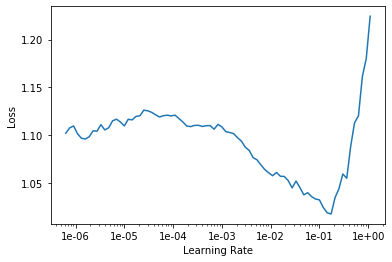

In [69]:
learn.recorder.plot()

In [70]:
learn.loss_func.func

CrossEntropyLoss()

In [71]:
kappa = KappaScore()

In [72]:
learn.metrics = [kappa, accuracy]

In [73]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,1.015373,1.017798,0.218945,0.477778,00:28


In [74]:
learn.save('first-full')

In [75]:
learn.load('first-full');

In [76]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.949500,0.887567,0.313482,0.538889,00:32


In [77]:
learn.save('second-full')

In [78]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.761290,0.865309,0.380933,0.583333,00:47
1,0.684996,0.954285,0.307082,0.538889,00:46
2,0.522194,0.763589,0.409891,0.605556,00:45
3,0.377466,0.815126,0.422916,0.616667,00:48
4,0.290734,0.805062,0.417637,0.611111,00:49


In [79]:
learn.save('final')